In [ ]:
## data는 어떻게 모으는가?

### 일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 댸
### 표준 python package를 이용하여 numpy 배열로 불러오면 됨
### 이후 torch.Tensor로 변환

# image = Pillow or OpenCV
# audio = SciPy or LibROSA
# text = python or Cpython, NLTK or SpaCy

## Vision 분야에서는 torchvision이라는 패키지가 만들어져있음
### 일반적으로 사용하는 이미지 데이터셋을 위한 데이터 로더(torchvision.datasets)와 이미지용 데이터 변환기 data transformer가 포함되어 있음


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     # 0 ~ 1 범위로 정규화
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))] 
     # Normalize((R의 평균, G의 평균, B의 평균), (R의 표준편차, G의 표준편차, B의 표준편차))
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


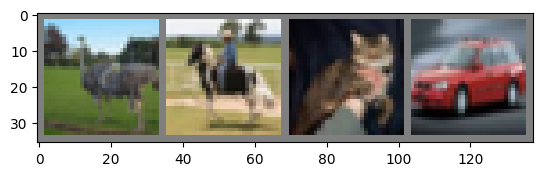

bird  horse cat   car  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # numpy화
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


# iterator를 불러와 무작위로 하나 가져옴
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))



In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        # 3 channel -> 6 channel
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 6 channel -> 16 channel
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 16 * 5 * 5 maps -> 120
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 각 conv 층은 relu 활성화 함수 통과
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화
        # 나머지 FC 층 모두 relu 활성화 함수 통과
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
net = Net()

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
epochs = 2

for epoch in range(epochs):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data

        optimizer.zero_grad() # gradient가 누적되므로, 0으로 초기화

        outputs = net(inputs) # 데이터를 넣고 결과를 받음 (순전파)
        loss = criterion(outputs, labels) # 예측 값과 실제 값 비교하여 loss 계산
        loss.backward() # 역전파로 업데이트
        optimizer.step() # 최적화

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.210
[1,  4000] loss: 1.863
[1,  6000] loss: 1.702
[1,  8000] loss: 1.615
[1, 10000] loss: 1.527
[1, 12000] loss: 1.493
[2,  2000] loss: 1.428
[2,  4000] loss: 1.384
[2,  6000] loss: 1.365
[2,  8000] loss: 1.338
[2, 10000] loss: 1.306
[2, 12000] loss: 1.315
Finished Training


In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

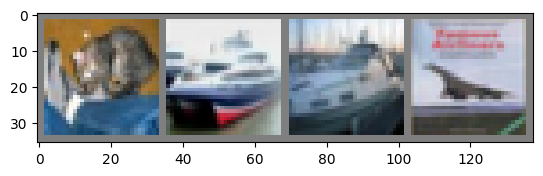

GroundTruth:  cat   ship  ship  plane


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
outputs = net(images)

In [40]:
images.shape

torch.Size([4, 3, 32, 32])

In [16]:
_, predicted = torch.max(outputs, 1) # 이미지에 따른 각 label 별 더 높은 값

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [17]:
correct = 0
total = 0

with torch.no_grad(): # 학습하는 것이 아니기 때문에 gradient 추적하지 않음
    for data in testloader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 들어온 데이터 수
        correct += (predicted == labels).sum().item() # 해당 배치에서 맞는 수를 더함


print(f'Accuracy of the network on the 10,000 test images: {100 * correct // total} %')

Accuracy of the network on the 10,000 test images: 53 %


In [18]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 60.1 %
Accuracy for class: car   is 61.8 %
Accuracy for class: bird  is 32.4 %
Accuracy for class: cat   is 38.2 %
Accuracy for class: deer  is 54.2 %
Accuracy for class: dog   is 35.4 %
Accuracy for class: frog  is 65.4 %
Accuracy for class: horse is 68.5 %
Accuracy for class: ship  is 76.3 %
Accuracy for class: truck is 47.4 %


In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


In [20]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
inputs, labels = data[0].to(device), data[1].to(device)

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class newNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,12,3)
        # 3 channel -> 6 channel
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(12, 24, 3)
        # 6 channel -> 16 channel
        self.fc1 = nn.Linear(24 * 6 * 6, 128)
        # 16 * 5 * 5 maps -> 120
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # 각 conv 층은 relu 활성화 함수 통과
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화
        # 나머지 FC 층 모두 relu 활성화 함수 통과
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
newnet = newNet()

In [60]:
newnet.to(device)

newNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=864, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

$$ Output\space size = \frac{\text{input size} - \text{filter size} + (2 * \text{padding})}{Stride} + 1 $$

In [61]:
(30 - 3 + (2 * 0) // 1) + 1

28

In [62]:
epochs = 2

for epoch in range(epochs):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # gradient가 누적되므로, 0으로 초기화

        outputs = newnet(inputs) # 데이터를 넣고 결과를 받음 (순전파)
        loss = criterion(outputs, labels) # 예측 값과 실제 값 비교하여 loss 계산
        loss.backward() # 역전파로 업데이트
        optimizer.step() # 최적화

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.304
[1,  4000] loss: 2.304
[1,  6000] loss: 2.303
[1,  8000] loss: 2.303
[1, 10000] loss: 2.304
[1, 12000] loss: 2.304
[2,  2000] loss: 2.304
[2,  4000] loss: 2.304
[2,  6000] loss: 2.304
[2,  8000] loss: 2.303
[2, 10000] loss: 2.305
[2, 12000] loss: 2.303
Finished Training
